In [63]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import fft
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco.admm import cbpdn

In [64]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

In [65]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, :])
np.random.seed(12345)
imgn = img + np.random.normal(0.0, 0.3, img.shape).astype(np.float32)

In [66]:
npd = 16
fltlmbd = 5.0
imgnl, imgnh = signal.tikhonov_filter(imgn, fltlmbd, npd)

In [67]:
D = util.convdicts()['G:8x8x128']

In [68]:
imgnpl, imgnph = signal.tikhonov_filter(pad(imgn), fltlmbd, npd)
W = fft.irfftn(np.conj(fft.rfftn(D, imgnph.shape, (0, 1))) *
               fft.rfftn(imgnph[..., np.newaxis], None, (0, 1)),
               imgnph.shape, (0,1))
W = W**2
W = 1.0/(np.maximum(np.abs(W), 1e-8))

lmbda = 4.8e-2

opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
            'HighMemSolve': True, 'RelStopTol': 3e-3, 'AuxVarObj': False,
            'L1Weight': W, 'AutoRho': {'Enabled': False}, 'rho': 4e2*lmbda})


In [69]:
b = cbpdn.ConvBPDN(D, pad(imgnh), lmbda, opt, dimK=0)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------
   0  2.64e+07  3.40e+02  5.49e+08  8.95e-01  2.89e-01
   1  9.84e+06  9.37e+02  2.05e+08  3.77e-01  4.71e-01
   2  1.11e+07  7.71e+02  2.32e+08  2.05e-01  4.47e-01
   3  9.29e+06  5.64e+02  1.94e+08  1.40e-01  3.18e-01
   4  6.06e+06  4.39e+02  1.26e+08  9.85e-02  2.67e-01
   5  4.33e+06  4.04e+02  9.02e+07  7.66e-02  2.44e-01
   6  3.52e+06  3.94e+02  7.34e+07  6.34e-02  2.01e-01
   7  3.00e+06  3.96e+02  6.25e+07  5.28e-02  1.64e-01
   8  2.54e+06  3.94e+02  5.30e+07  4.38e-02  1.44e-01
   9  2.23e+06  3.88e+02  4.65e+07  3.67e-02  1.32e-01
  10  1.95e+06  3.79e+02  4.06e+07  3.13e-02  1.22e-01
  11  1.71e+06  3.70e+02  3.57e+07  2.70e-02  1.13e-01
  12  1.51e+06  3.61e+02  3.13e+07  2.37e-02  1.05e-01
  13  1.35e+06  3.54e+02  2.81e+07  2.10e-02  9.86e-02
  14  1.23e+06  3.48e+02  2.56e+07  1.88e-02  9.30e-02
  15  1.14e+06  3.44e+02  2.38e+07  1.71e-02  8.80e-02
  16  1.07

 147  4.80e+04  3.04e+02  9.95e+05  7.41e-04  7.08e-03
 148  4.74e+04  3.04e+02  9.82e+05  7.33e-04  7.00e-03
 149  4.68e+04  3.04e+02  9.69e+05  7.25e-04  6.93e-03
 150  4.63e+04  3.04e+02  9.57e+05  7.17e-04  6.86e-03
 151  4.56e+04  3.04e+02  9.45e+05  7.09e-04  6.79e-03
 152  4.51e+04  3.04e+02  9.34e+05  7.02e-04  6.73e-03
 153  4.46e+04  3.04e+02  9.22e+05  6.95e-04  6.66e-03
 154  4.40e+04  3.04e+02  9.11e+05  6.87e-04  6.59e-03
 155  4.36e+04  3.04e+02  9.01e+05  6.80e-04  6.53e-03
 156  4.30e+04  3.04e+02  8.90e+05  6.73e-04  6.46e-03
 157  4.26e+04  3.04e+02  8.80e+05  6.66e-04  6.40e-03
 158  4.21e+04  3.04e+02  8.70e+05  6.59e-04  6.34e-03
 159  4.16e+04  3.04e+02  8.60e+05  6.52e-04  6.28e-03
 160  4.11e+04  3.04e+02  8.50e+05  6.46e-04  6.22e-03
 161  4.07e+04  3.04e+02  8.41e+05  6.40e-04  6.16e-03
 162  4.02e+04  3.04e+02  8.31e+05  6.33e-04  6.11e-03
 163  3.97e+04  3.04e+02  8.21e+05  6.27e-04  6.05e-03
 164  3.93e+04  3.04e+02  8.12e+05  6.20e-04  5.99e-03
 165  3.88

In [70]:
imgdp = b.reconstruct().squeeze()
imgd = np.clip(crop(imgdp) + imgnl, 0, 1)

In [71]:
print("ConvBPDN solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % metric.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % metric.psnr(img, imgd))

ConvBPDN solve time: 585.99 s
Noisy image PSNR:     9.13 dB
Denoised image PSNR: 12.52 dB


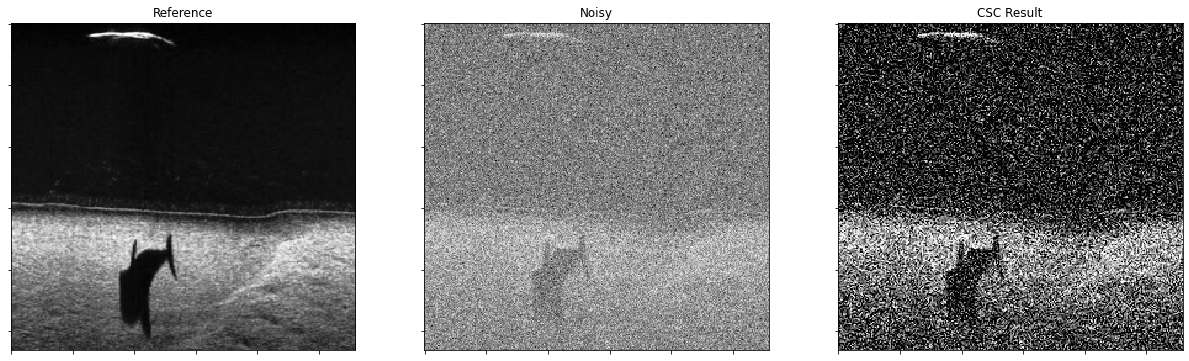

In [72]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgn, title='Noisy', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgd, title='CSC Result', fig=fig)
fig.show()

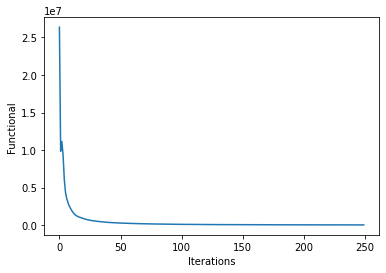

In [73]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')

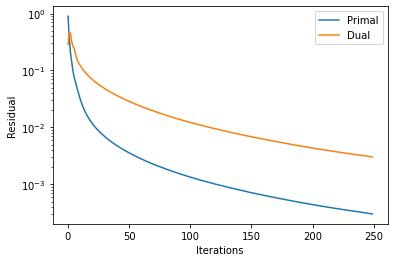

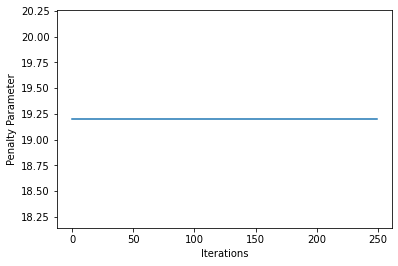

In [74]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')

In [75]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 


0.08298676648569105
